In [ ]:
import numpy as np
import muon as mu
import scanpy as sc
import anndata as ad
import os
import random
from models import scSpecies
import torch
import json
from create_datasets.preprocessing import set_random_seed

%load_ext autoreload
%autoreload 2

set_random_seed(1234)

path = os.path.abspath('').replace('\\', '/')+'/'
data_path = path+'dataset/'
save_path = os.path.abspath('').replace('\\', '/')+'/results/'

device = "mps"#("cuda" if torch.cuda.is_available() else "mps")
h_dict = {'k_neigh': 25,  'alignment': 'latent'}

dataset = "liver_human"
load_key = 'liver'    

mdata = mu.read_h5mu(data_path+"liver.h5mu")

human_model = scSpecies(device, mdata, path, context_dataset_key = 'mouse', target_dataset_key = 'human', random_seed = 1234, top_percent=20)
mouse_model = scSpecies(device, mdata, path, context_dataset_key = 'mouse', target_dataset_key = 'mouseNafld', random_seed = 1234, top_percent=20)
pig_model = scSpecies(device, mdata, path, context_dataset_key = 'mouse', target_dataset_key = 'pig', random_seed = 1234, top_percent=50)
monkey_model = scSpecies(device, mdata, path, context_dataset_key = 'mouse', target_dataset_key = 'monkey', random_seed = 1234, top_percent=50)
chicken_model = scSpecies(device, mdata, path, context_dataset_key = 'mouse', target_dataset_key = 'chicken', random_seed = 1234, top_percent=50)
hamster_model = scSpecies(device, mdata, path, context_dataset_key = 'mouse', target_dataset_key = 'hamster', random_seed = 1234, top_percent=50)

human_model.train_context(30, save_model=False)
human_model.eval_context()
human_model.train_target(30, save_model=False)
human_model.eval_target()
human_model.save_params('_mouse', save='context', name='')
human_model.save_params('_human', save='target', name='')

mouse_model.load_params('_mouse', 'context_encoder')
mouse_model.train_target(30, save_model=False)
mouse_model.eval_target()
mouse_model.save_params('_mouseNafld', save='target', name='')

pig_model.load_params('_mouse', 'context_encoder')
pig_model.train_target(30, save_model=False)
pig_model.eval_target()
pig_model.save_params('_pig', save='target', name='')

monkey_model.load_params('_mouse', 'context_encoder')
monkey_model.train_target(60, save_model=False)
monkey_model.eval_target()
monkey_model.save_params('_monkey', save='target', name='')

chicken_model.load_params('_mouse', 'context_encoder')
chicken_model.train_target(60, save_model=False)
chicken_model.eval_target()
chicken_model.save_params('_chicken', save='target', name='')

hamster_model.load_params('_mouse', 'context_encoder')
hamster_model.train_target(60, save_model=False)
hamster_model.eval_target()
hamster_model.save_params('_hamster', save='target', name='')

human_model.eval_label_transfer([('cell_type_coarse', 'cell_type_coarse')])
mouse_model.eval_label_transfer([('cell_type_coarse', 'cell_type_coarse')])
pig_model.eval_label_transfer([('cell_type_coarse', 'cell_type_coarse')])
monkey_model.eval_label_transfer([('cell_type_coarse', 'cell_type_coarse')])
chicken_model.eval_label_transfer([('cell_type_coarse', 'cell_type_coarse')])
hamster_model.eval_label_transfer([('cell_type_coarse', 'cell_type_coarse')])


umap_together = ad.AnnData(
    np.concatenate(
        (human_model.mdata.mod['mouse'].obsm['latent_mu'],
        mouse_model.mdata.mod['mouseNafld'].obsm['latent_mu'], 
        human_model.mdata.mod['human'].obsm['latent_mu'], 
        pig_model.mdata.mod['pig'].obsm['latent_mu'], 
        monkey_model.mdata.mod['monkey'].obsm['latent_mu'], 
        chicken_model.mdata.mod['chicken'].obsm['latent_mu'], 
        hamster_model.mdata.mod['hamster'].obsm['latent_mu'])
        )
        )

sc.pp.neighbors(umap_together)
sc.tl.umap(umap_together)

umap_together.obs['species'] = np.array(
    ['mouse']*human_model.mdata.mod['mouse'].n_obs+['mouseNafld']*mouse_model.mdata.mod['mouseNafld'].n_obs+['human']*human_model.mdata.mod['human'].n_obs+['pig']*pig_model.mdata.mod['pig'].n_obs+['monkey']*monkey_model.mdata.mod['monkey'].n_obs+['chicken']*chicken_model.mdata.mod['chicken'].n_obs+['hamster']*hamster_model.mdata.mod['hamster'].n_obs)

umap_together.obs['cell_type_coarse'] = np.concatenate(
    (human_model.mdata.mod['mouse'].obs['cell_type_coarse'], 
     mouse_model.mdata.mod['mouseNafld'].obs['cell_type_coarse'], 
     human_model.mdata.mod['human'].obs['cell_type_coarse'], 
     pig_model.mdata.mod['pig'].obs['cell_type_coarse'], 
     monkey_model.mdata.mod['monkey'].obs['cell_type_coarse'], 
     chicken_model.mdata.mod['chicken'].obs['cell_type_coarse'], 
     hamster_model.mdata.mod['hamster'].obs['cell_type_coarse']
     )
     )

In [2]:
import glasbey

def return_palette(names):
    
    known_cell_types = {
        'B Cells': ('#964b00', 'Lymphoid Cells', 'B cell lineage'),
        'B/Plasma': ('#6F4E37', 'Lymphoid Cells', 'B cell lineage'),
        'Plasma': ('#c19a6b', 'Lymphoid Cells', 'B cell lineage'),

        'Naive CD8+ T': ('#A8E4A0', 'Lymphoid Cells', 'Cytotoxic T Cells'),        
        'Circ. Eff. Memory T': ('#98FB98', 'Lymphoid Cells', 'Cytotoxic T Cells'),
        'Cytotoxic CD8+': ('#A7F432', 'Lymphoid Cells', 'Cytotoxic T Cells'),
        'RM CD8+ T Cells': ('#D0F0C0', 'Lymphoid Cells', 'Cytotoxic T Cells'),
        'RM CD8+ T cells': ('#D0F0C0', 'Lymphoid Cells', 'Cytotoxic T Cells'),
        'CD8 Eff. Memory T': ('#D1FFBD', 'Lymphoid Cells', 'Cytotoxic T Cells'),        
        'Gamma-Delta T': ('#9acd32', 'Lymphoid Cells', 'Specialized T Cells'),
        'T Cells': ('#4CBB17', 'Lymphoid Cells', 'T Cells'),
        'T Cells 1': ('#08A04B', 'Lymphoid Cells', 'T Cells'),
        'T Cells 2': ('#227442', 'Lymphoid Cells', 'T Cells'),
        'T Cells 3': ('#254117', 'Lymphoid Cells', 'T Cells'),
        'Naive CD4+ T': ('#48A860', 'Lymphoid Cells', 'T helper Cells'),
        'CD4+ T helper': ('#50a88b', 'Lymphoid Cells', 'T helper Cells'),
        'Naive/CM CD4+ T': ('#2E8B57', 'Lymphoid Cells', 'T helper Cells'),
        'Th 17': ('#00A86B', 'Lymphoid Cells', 'T helper Cells'),
        'Th 1': ('#50C878', 'Lymphoid Cells', 'T helper Cells'),
        'CD4+ KLRB1 Th': ('#74C365', 'Lymphoid Cells', 'T helper Cells'),
        'Regulatory T': ('#0B6623',	'Lymphoid Cells', 'T helper Cells'),
        'Circ. NK': ('#8F9779', 'Lymphoid Cells', 'NK/NKT'),
        'Tissue Resident NK': ('#708238', 'Lymphoid Cells', 'NK/NKT'),
        'NK Cells': ('#568203', 'Lymphoid Cells', 'NK/NKT'),
        'NK/NKT Cells': ('#839B17', 'Lymphoid Cells', 'NK/NKT'),
        'NKT Cells': ('#043927', 'Lymphoid Cells' , 'NK/NKT'),     
         
        
        'ILCs': ('#7fff00', 'Lymphoid Cells', 'Innate lymphoid Cells'),
        'Prol. TAM': ('#93FFE8', 'Myeloid Cells', 'Tumor associated macrophages'),
        
        'Mg-TAM': ('#DA2C43', 'Myeloid Cells', 'Mg-TAM'),
        'Hypoxic Mg-TAM': ('#A50B5E', 'Myeloid Cells', 'Mg-TAM'),
        'IFN Mg-TAM': ('#F64A8A', 'Myeloid Cells', 'Mg-TAM'),
        'Phago/Lipid Mg-TAM': ('#F987C5', 'Myeloid Cells', 'Mg-TAM'),
        
        'Mo-TAM': ('#00637C', 'Myeloid Cells', 'Mo-TAM'),
        'IFN Mo-TAM': ('#005F5F', 'Myeloid Cells', 'Mo-TAM'),
        'Lipid Mo-TAM': ('#008794', 'Myeloid Cells', 'Mo-TAM'),
        'Hypoxic Mo-TAM': ('#5F9EA0', 'Myeloid Cells', 'Mo-TAM'),
        'SEPP1+ Mo-TAM': ('#80fdff', 'Myeloid Cells', 'Mo-TAM'),
        'Transitory Mo-TAM': ('#00d9dc', 'Myeloid Cells', 'Mo-TAM'),

        'Macrophages 1': ('#151B54', 'Myeloid Cells', 'Macrophages'),
        'Macrophages 2': ('#191970', 'Myeloid Cells', 'Macrophages'),
        'Macrophages 3': ('#0000A5', 'Myeloid Cells', 'Macrophages'),
        'Macrophages 4': ('#0000CD', 'Myeloid Cells', 'Macrophages'),
        'Bile-duct LAMs': ('#5865F2', 'Myeloid Cells', 'Macrophages'),
        'MoMac1': ('#0020C2', 'Myeloid Cells', 'Macrophages'),
        'MoMac2': ('#0041C2', 'Myeloid Cells', 'Macrophages'),
        'Peritoneal Macs': ('#6960EC',  'Myeloid Cells', 'Macrophages'),
        'CV/Capsule': ('#1D2951', 'Myeloid Cells', 'Macrophages'),        
        'CV/Capsule Cd207+ Macs': ('#1D2951', 'Myeloid Cells', 'Macrophages'),
        'Macrophages': ('#101D6B', 'Myeloid Cells', 'Macrophages'),
        'immLAMs': ('#000080', 'Myeloid Cells', 'Macrophages'),
        'matLAMs': ('#1035AC', 'Myeloid Cells', 'Macrophages'),
        'Monocytes 1': ('#1974D2', 'Myeloid Cells', 'Mono/mono derived'),
        'Monocytes 2': ('#0909FF', 'Myeloid Cells', 'Mono/mono derived'),   
        'Mono/mono-derived': ("#4176e0", 'Myeloid Cells', 'Mono/mono derived'), 
        'Trans. Monocytes': ('#6495ED', 'Myeloid Cells', 'Mono/mono derived'),
        'Trans. Monocytes 1': ('#b5d7fd', 'Myeloid Cells', 'Mono/mono derived'),               
        'Trans. Monocytes 2': ('#82EEFD', 'Myeloid Cells', 'Mono/mono derived'),
        'Monocytes': ('#87CDEE', 'Myeloid Cells', 'Mono/mono derived'),
        'Pat. Monocytes': ('#008ECC', 'Myeloid Cells', 'Mono/mono derived'),
        'Pre-moKCs and moKCs': ('#38ACEC', 'Myeloid Cells', 'Mono/mono derived'),
        'KCs': ("#00bbf9", 'Myeloid Cells', 'Mono/mono derived'),
        
        'Basophils': ('#000000', 'Myeloid Cells', 'Granulocytes'),
        'Mast Cells': ('#00CC99', 'Myeloid Cells', 'Mast Cells'),
        'Neutrophils': ('#8c8784', 'Myeloid Cells', 'Granulocytes'),
        'ASDC': ('#483D8B', 'Myeloid Cells', 'Dendritic Cells'),
        'DCs': ('#80008B', 'Myeloid Cells', 'Dendritic Cells'),
        'DCs 3': ('#342D7E', 'Myeloid Cells', 'Dendritic Cells'),
        'Mig. DCs': ('#8f00ff', 'Myeloid Cells', 'Dendritic Cells'),
        'cDCs': ('#80008B', 'Myeloid Cells', 'Dendritic Cells'),
        'cDCs 1': ('#81007F', 'Myeloid Cells', 'Dendritic Cells'),
        'Prol. cDCs 1': ('#B041FF', 'Myeloid Cells', 'Dendritic Cells'),
        'pre-DC': ('#36013F', 'Myeloid Cells', 'Dendritic Cells'),
        'cDCs 2': ('#6F2DA8', 'Myeloid Cells', 'Dendritic Cells'),
        'Prol. cDCs 2': ('#4B0082', 'Myeloid Cells', 'Dendritic Cells'),
        'pDCs': ('#D891EF', 'Myeloid Cells', 'Dendritic Cells'),
        'Endothelials': ('#ffbf00', 'CD45- Cells', 'Endothelials'),
        'Endothelials A1': ('#D2691E', 'CD45- Cells', 'Endothelials'),
        'Endothelials A2': ('#CC6600', 'CD45- Cells', 'Endothelials'), 
        'Endothelials M': ('#E66C2C', 'CD45- Cells', 'Endothelials'),
        'Endothelials S1': ('#FF6700', 'CD45- Cells', 'Endothelials'),
        'Endothelials S2': ('#FF5F1F', 'CD45- Cells', 'Endothelials'),
        'Endothelials S3': ('#FE632A', 'CD45- Cells', 'Endothelials'),
        'Endothelials V': ('#F87217', 'CD45- Cells', 'Endothelials'),
        'Central Vein ECs': ('#fcc200', 'CD45- Cells', 'Endothelials'),
        'LSECs': ('#ffa700', 'CD45- Cells', 'Endothelials'),
        'Lymphatic ECs': ('#FCE205', 'CD45- Cells', 'Endothelials'),
        'Lymphatic ECs 1': ('#C35817', 'CD45- Cells', 'Endothelials'),
        'Lymphatic ECs 2': ('#C04000', 'CD45- Cells', 'Endothelials'),
        'Portal Vein ECs': ('#ffd700', 'CD45- Cells', 'Endothelials'),
        'Female Epithelials': ('#F433FF', 'CD45- Cells', 'Epithelial/epithelial-like'),
        'Endometrium': ('#FF8C00', 'CD45- Cells', 'Epithelial/epithelial-like'),        
        'Female Epithelials AV': ('#FF77FF', 'CD45- Cells', 'Epithelial/epithelial-like'),
        'Female Epithelials HS': ('#FF00FF', 'CD45- Cells', 'Epithelial/epithelial-like'),
        'Male Epithelials': ('#A74AC7', 'CD45- Cells', 'Epithelial/epithelial-like'),
        'Male Epithelials 1': ('#B048B5', 'CD45- Cells', 'Epithelial/epithelial-like'),
        'Male Epithelials 2': ('#B666D2', 'CD45- Cells', 'Epithelial/epithelial-like'),
        'Male Epithelials 3': ('#7E587E', 'CD45- Cells', 'Epithelial/epithelial-like'), 
        'Mesothelial Cells': ('#E0115F', 'CD45- Cells', 'Epithelial/epithelial-like'),
        'Mesothelial 1': ('#FF4500', 'CD45- Cells', 'Epithelial/epithelial-like'),
        'Mesothelial 2': ('#E55451', 'CD45- Cells', 'Epithelial/epithelial-like'),
        'Mesothelial 3': ('#E55B3C', 'CD45- Cells', 'Epithelial/epithelial-like'),
        'Hepatocytes': ('#ff0090', 'CD45- Cells', 'Epithelial/epithelial-like'),        
        'Cholangiocytes': ('#c90016', 'CD45- Cells', 'Epithelial/epithelial-like'),
        'Capsule Fibroblasts': ('#cf1020', 'CD45- Cells', 'Structural/connective tissue'),
        'Fibroblasts': ('#ff3800', 'CD45- Cells', 'Structural/connective tissue'),
        'Fibroblast 1': ('#f08080', 'CD45- Cells', 'Structural/connective tissue'),
        'Fibroblast 2': ('#ff4500', 'CD45- Cells', 'Structural/connective tissue'),
        'Stromal':  ('#ff4500', 'CD45- Cells', 'Structural/connective tissue'),
        'Mammary Fibroblasts': ('#CC338B', 'CD45- Cells', 'Structural/connective tissue'),        
        'Stellate Cells': ('#ff033e', 'CD45- Cells', 'Structural/connective tissue'),        
        'Adipocytes': ('#FF2400', 'CD45- Cells', 'Structural/connective tissue'),
        'Adipocytes 1': ('#FFFF33', 'CD45- Cells', 'Structural/connective tissue'),
        'Adipocytes 2': ('#FFEF00', 'CD45- Cells', 'Structural/connective tissue'),
        'Adipocytes 3': ('#FAF884', 'CD45- Cells', 'Structural/connective tissue'),
        'Adipocytes 4': ('#FFE87C', 'CD45- Cells', 'Structural/connective tissue'),
        'Adipocytes 5': ('#FFDB58', 'CD45- Cells', 'Structural/connective tissue'),
        'Adipocytes 6': ('#FFDF00', 'CD45- Cells', 'Structural/connective tissue'),
        'Adipocytes 7': ('#F9DB24', 'CD45- Cells', 'Structural/connective tissue'),
        'Preadipocytes': ('#C60615', 'CD45- Cells', 'Structural/connective tissue'),
        'Preadipocytes 1': ('#FBB917', 'CD45- Cells', 'Structural/connective tissue'),
        'Preadipocytes 2': ('#FDBD01', 'CD45- Cells', 'Structural/connective tissue'),
        'Preadipocytes 3': ('#FBB117', 'CD45- Cells', 'Structural/connective tissue'),
        'Preadipocytes 4': ('#FFAE42', 'CD45- Cells', 'Structural/connective tissue'),
        'Preadipocytes 5': ('#F2BB66', 'CD45- Cells', 'Structural/connective tissue'),
        'Preadipocytes 6': ('#FFCE44', 'CD45- Cells', 'Structural/connective tissue'),
        'Pericytes': ('#FE5BAC', 'CD45- Cells', 'Structural/connective tissue'),
        'Smooth Muscle Cells': ('#B5338A', 'CD45- Cells', 'Structural/connective tissue'),
        'Myo Epithelials': ('#98AFC7', 'CD45- Cells', 'Structural/connective tissue'),
        'Platelets': ('#837E7C', 'CD45- Cells', 'Platelets'),
    }

    name_list = np.unique(names)
    lenght = 10 + len(name_list)
    colors = glasbey.extend_palette("tab10", palette_size=lenght)

    palette = {}

    j=0
    for name in name_list:       
        if name in known_cell_types.keys():
            palette[name] = known_cell_types[name]#[0]
        else: 
            print('\nAssingning color to unknown cell type: '+name)
            palette[name] = (colors[j], )
            j+=1
            
    return palette

/Users/cschaech/anaconda3/envs/scSpecies_env/lib/python3.11/site-packages/matplotlib_inline/backend_inline.py:27: UserWarning: The Figure parameters 'layout' and 'constrained_layout' cannot be used together. Please use 'layout' only.
  return new_figure_manager_given_figure(num, FigureClass(*args, **kwargs))
/Users/cschaech/anaconda3/envs/scSpecies_env/lib/python3.11/site-packages/textalloc/__init__.py:500: UserWarning: Usage of allocate_text will be replaced with allocate in future releases, removing the need for the fig argument
  warnings.warn(


Creating boxes


100%|██████████| 15/15 [00:00<00:00, 3564.77it/s]


Processing


100%|██████████| 15/15 [00:02<00:00,  5.09it/s]


Plotting
Finished in 13.481264114379883s
Creating boxes


100%|██████████| 14/14 [00:00<00:00, 7121.06it/s]


Processing


100%|██████████| 14/14 [00:01<00:00,  8.75it/s]


Plotting
Finished in 10.539419889450073s
Creating boxes


100%|██████████| 15/15 [00:00<00:00, 5776.22it/s]


Processing


100%|██████████| 15/15 [00:02<00:00,  5.88it/s]
/Users/cschaech/anaconda3/envs/scSpecies_env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cschaech/anaconda3/envs/scSpecies_env/lib/python3.11/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Plotting
Finished in 12.863195896148682s
Creating boxes


100%|██████████| 9/9 [00:00<00:00, 6797.90it/s]


Processing


100%|██████████| 9/9 [00:00<00:00, 48.43it/s]

Plotting
Finished in 7.799155950546265s


Creating boxes


100%|██████████| 7/7 [00:00<00:00, 9320.68it/s]


Processing


100%|██████████| 7/7 [00:00<00:00, 102.12it/s]


Plotting
Finished in 7.437607049942017s
Creating boxes


100%|██████████| 9/9 [00:00<00:00, 8071.14it/s]


Processing


100%|██████████| 9/9 [00:00<00:00, 68.14it/s]

Plotting
Finished in 7.349858045578003s


Creating boxes


100%|██████████| 11/11 [00:00<00:00, 5215.62it/s]


Processing


100%|██████████| 11/11 [00:00<00:00, 83.49it/s]

Plotting
Finished in 7.312238693237305s


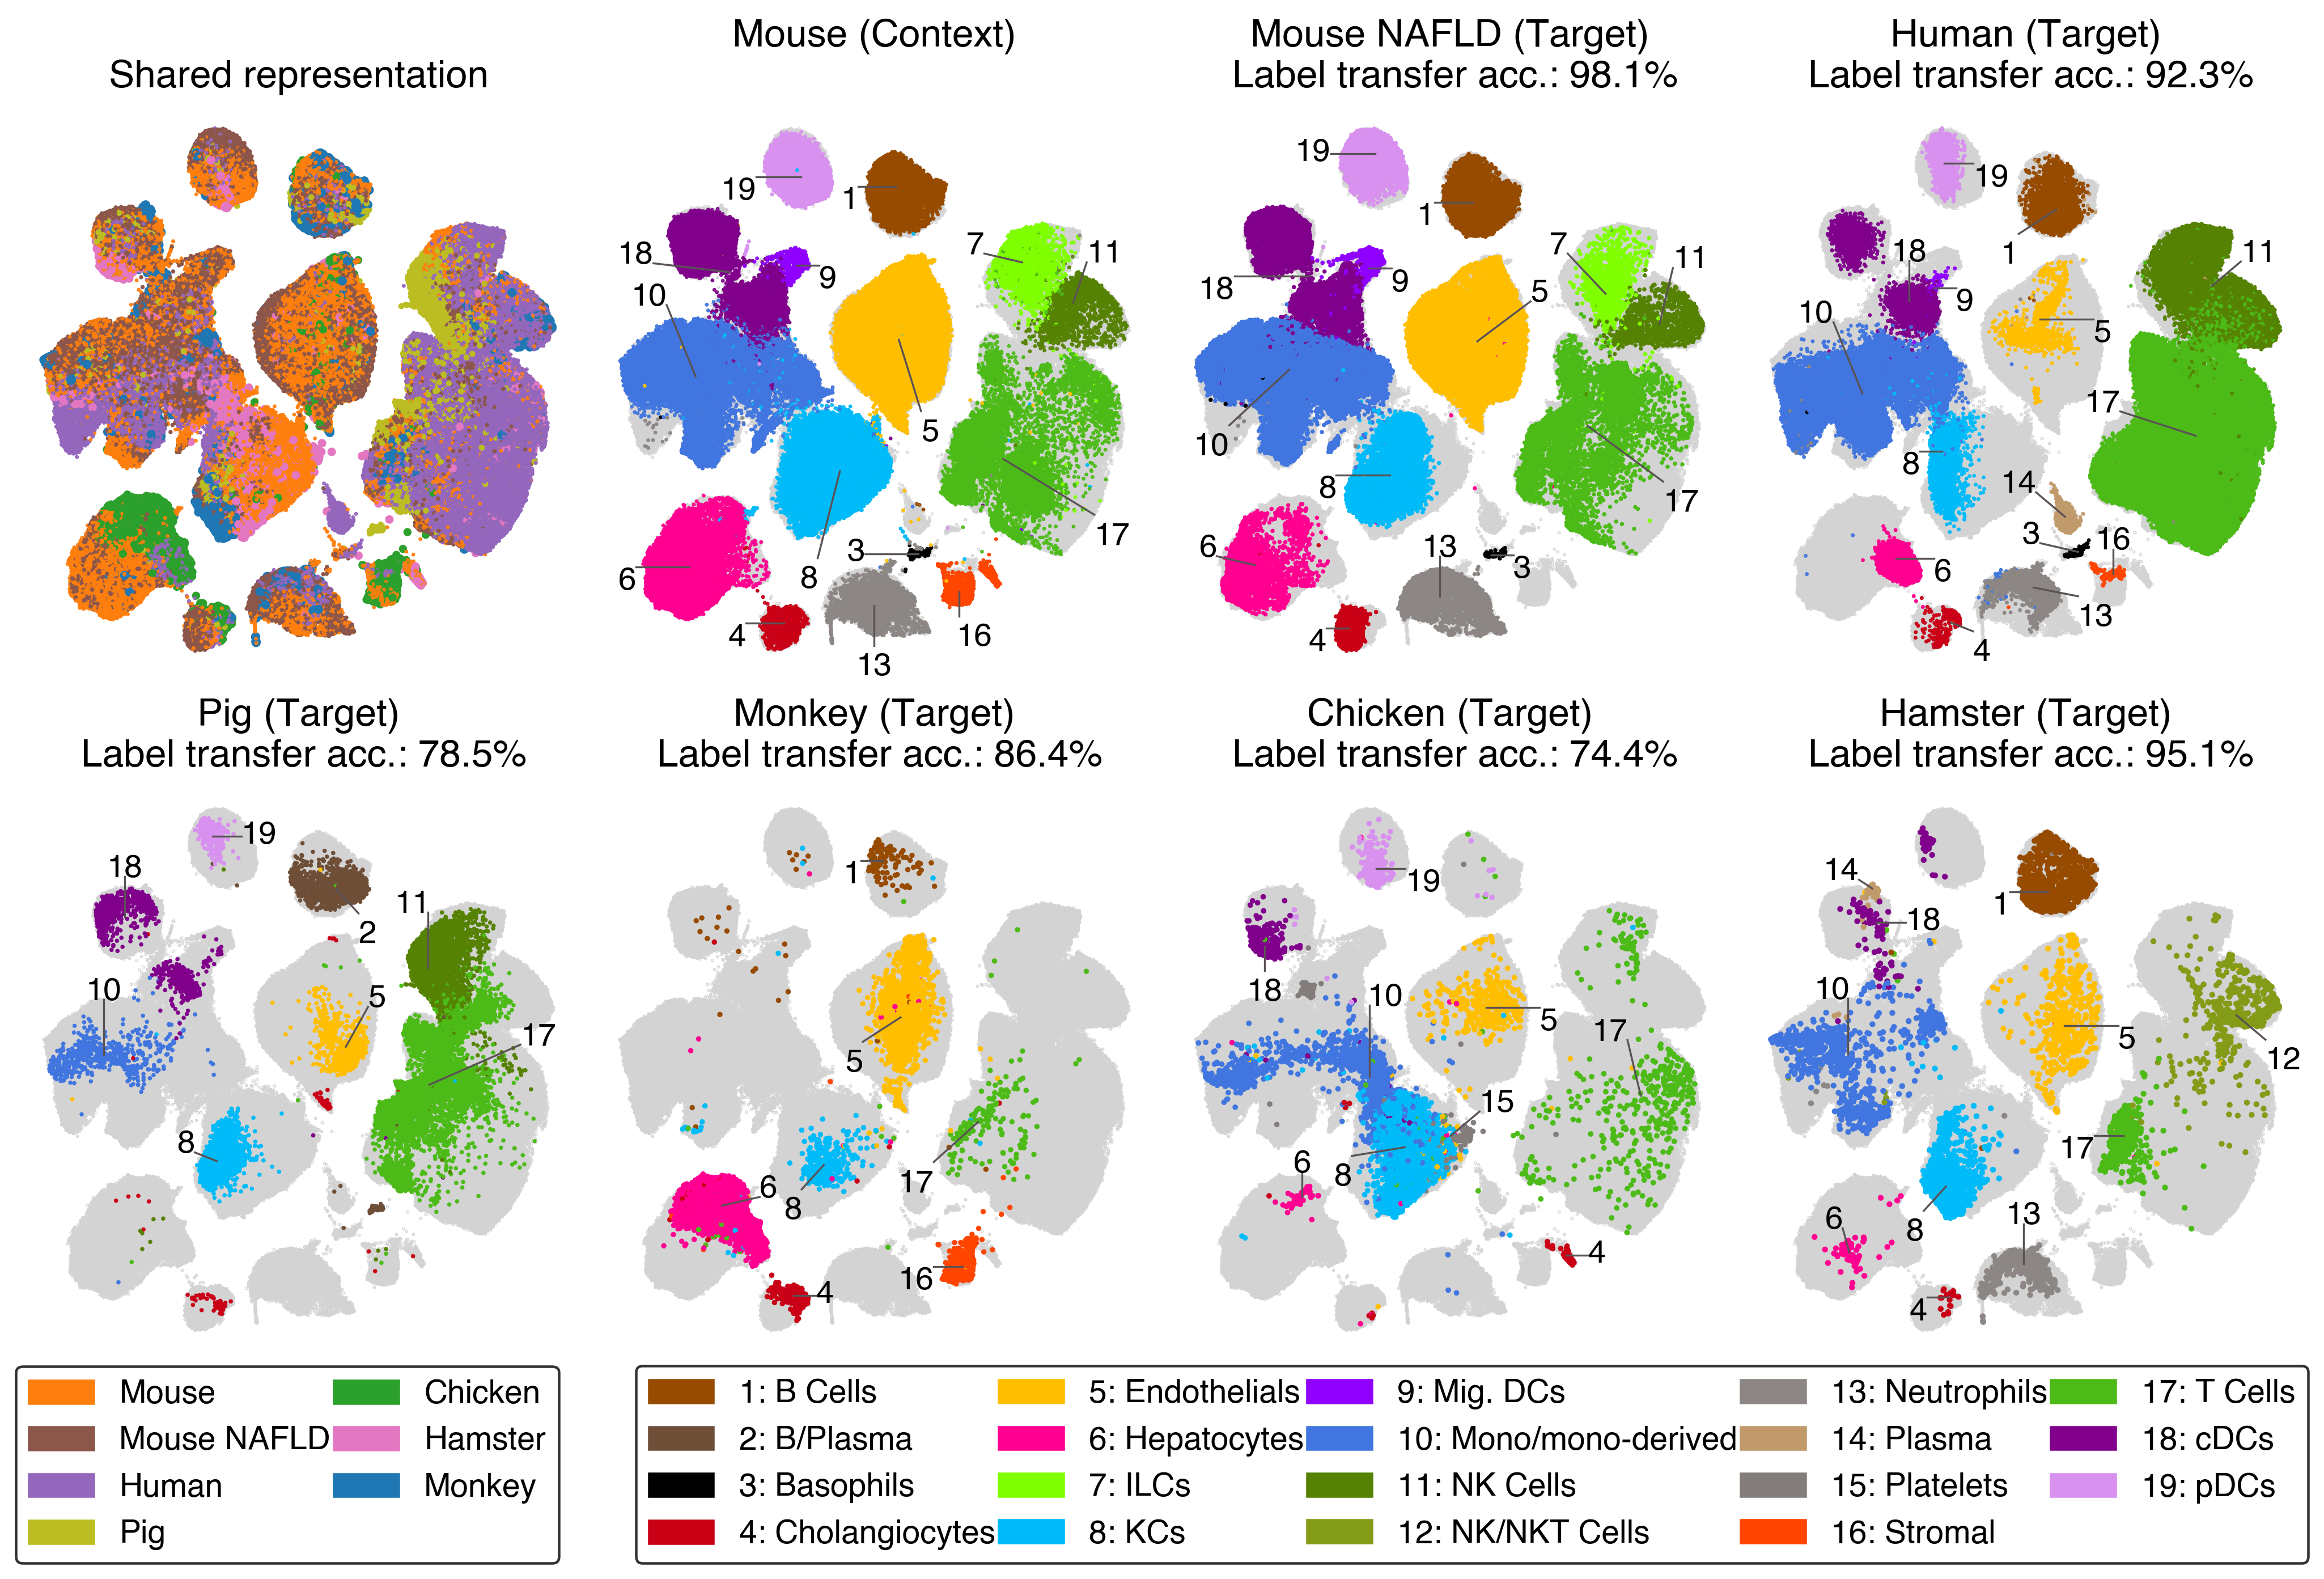

In [6]:
import numpy as np
import textalloc as ta
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib

matplotlib.rcParams['font.family'] = 'Helvetica'

fig, ((ax_1, ax_2, ax_3, ax_4), (ax_5, ax_6, ax_7, ax_8)) = plt.subplots(2, 4, figsize=(12.5,8.5), constrained_layout=True, dpi=325, layout='constrained')

fontsize = 20

a = mdata.mod['mouse'].n_obs
b = mdata.mod['mouseNafld'].n_obs
c = mdata.mod['human'].n_obs
d = mdata.mod['pig'].n_obs
e = mdata.mod['monkey'].n_obs
f = mdata.mod['chicken'].n_obs
g = mdata.mod['hamster'].n_obs

ax_1.set_title('Shared representation', fontsize=15)
ax_2.set_title('Mouse (Context)\n', fontsize=15)
ax_3.set_title('Mouse NAFLD (Target)\n Label transfer acc.: {}%'.format(
    round(100*hamster_model.mdata.mod['mouseNafld'].uns['metrics_cell_type_coarse']['balanced_accuracy_score_nns_aligned_latent_space'],1)), fontsize=15)
ax_4.set_title('Human (Target)\n Label transfer acc.: {}%'.format(
    round(100*hamster_model.mdata.mod['human'].uns['metrics_cell_type_coarse']['balanced_accuracy_score_nns_aligned_latent_space'],1)), fontsize=15)
ax_5.set_title('Pig (Target)\n Label transfer acc.: {}%'.format(
    round(100*hamster_model.mdata.mod['pig'].uns['metrics_cell_type_coarse']['balanced_accuracy_score_nns_aligned_latent_space'],1)), fontsize=15)
ax_6.set_title('Monkey (Target)\n Label transfer acc.: {}%'.format(
    round(100*hamster_model.mdata.mod['monkey'].uns['metrics_cell_type_coarse']['balanced_accuracy_score_nns_aligned_latent_space'],1)), fontsize=15)
ax_7.set_title('Chicken (Target)\n Label transfer acc.: {}%'.format(
    round(100*hamster_model.mdata.mod['chicken'].uns['metrics_cell_type_coarse']['balanced_accuracy_score_nns_aligned_latent_space'],1)), fontsize=15)
ax_8.set_title('Hamster (Target)\n Label transfer acc.: {}%'.format(
    round(100*hamster_model.mdata.mod['hamster'].uns['metrics_cell_type_coarse']['balanced_accuracy_score_nns_aligned_latent_space'],1)), fontsize=15)

for ax in [ax_1, ax_2, ax_3, ax_4, ax_5, ax_6, ax_7, ax_8]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

perm = np.random.permutation(len(umap_together))

ind = np.random.choice(np.arange(umap_together.n_obs), replace=False, size=10000)
umap_sub = umap_together.obsm['X_umap']  #

ax_1.scatter(umap_sub[:,0][perm], umap_sub[:,1][perm], s=np.array([40000/a] * a +[40000/b] * b +[40000/c] * c +[40000/d] * d +[40000/e] * e +[40000/f] * f +[40000/g] * g)[perm], c=np.array(['tab:orange'] * a +['tab:brown'] * b +['tab:purple'] * c +['tab:olive'] * d +['tab:green'] * e +['tab:pink'] * f +['tab:blue'] * g)[perm])
ax_2.scatter(umap_sub[:,0], umap_sub[:,1], s=40000/len(umap_sub), c='lightgray')
ax_3.scatter(umap_sub[:,0], umap_sub[:,1], s=40000/len(umap_sub), c='lightgray')
ax_4.scatter(umap_sub[:,0], umap_sub[:,1], s=40000/len(umap_sub), c='lightgray')
ax_5.scatter(umap_sub[:,0], umap_sub[:,1], s=40000/len(umap_sub), c='lightgray')
ax_6.scatter(umap_sub[:,0], umap_sub[:,1], s=40000/len(umap_sub), c='lightgray')
ax_7.scatter(umap_sub[:,0], umap_sub[:,1], s=40000/len(umap_sub), c='lightgray')
ax_8.scatter(umap_sub[:,0], umap_sub[:,1], s=40000/len(umap_sub), c='lightgray')

labels_1 = ['Mouse', 'Mouse NAFLD', 'Human', 'Pig', 'Chicken', 'Hamster', 'Monkey']

palette_cells = {
    'Mouse': 'tab:orange', 
    'Mouse NAFLD': 'tab:brown', 
    'Human': 'tab:purple', 
    'Pig': 'tab:olive', 
    'Monkey': 'tab:blue',
    'Chicken': 'tab:green', 
    'Hamster': 'tab:pink',
}

transl = {
    'Endothelial': 'Endothelials',
    'Mig. cDCs': 'Mig. DCs',
    'Mono/Mono Derived': 'Mono/mono-derived',
    'NK/NKT cells': 'NK/NKT Cells'
    }

labels_2 = mdata.mod['mouse'].obs['cell_type_coarse'].to_numpy()
labels_2 =np.array([transl.get(l, l) for l in labels_2])
labels_3 = mdata.mod['mouseNafld'].obs['cell_type_coarse'].to_numpy()
labels_3 =np.array([transl.get(l, l) for l in labels_3])
labels_4 = mdata.mod['human'].obs['cell_type_coarse'].to_numpy()
labels_4 =np.array([transl.get(l, l) for l in labels_4])
labels_5 = mdata.mod['pig'].obs['cell_type_coarse'].to_numpy()
labels_5 =np.array([transl.get(l, l) for l in labels_5])
labels_6 = mdata.mod['monkey'].obs['cell_type_coarse'].to_numpy()
labels_6 =np.array([transl.get(l, l) for l in labels_6])
labels_7 = mdata.mod['chicken'].obs['cell_type_coarse'].to_numpy()
labels_7 =np.array([transl.get(l, l) for l in labels_7])
labels_8 = mdata.mod['hamster'].obs['cell_type_coarse'].to_numpy()
labels_8 =np.array([transl.get(l, l) for l in labels_8])
labels_cells = np.unique(np.concatenate((labels_2, labels_3, labels_4, labels_5, labels_6, labels_7, labels_8)))


ct_dict = return_palette([ct for ct in labels_cells])
ct_dict = sorted(ct_dict.items(), key=lambda x: (x[1][1], x[1][2]))
ct_dict = {k: (v[0], transl.get(k, k), v[2], i + 1) for i, (k, v) in enumerate(ct_dict)}

colors_2 = [ct_dict[ct][0] for ct in labels_2]
scatter_ax_2 = ax_2.scatter(umap_sub[:a,0], umap_sub[:a,1], s=40000/a, c=colors_2)

colors_3 = [ct_dict[ct][0] for ct in labels_3]
scatter_ax_3 = ax_3.scatter(umap_sub[a:a+b,0], umap_sub[a:a+b,1], s=40000/b, c=colors_3)

colors_4 = [ct_dict[ct][0] for ct in labels_4]
scatter_ax_4 = ax_4.scatter(umap_sub[a+b:a+b+c,0], umap_sub[a+b:a+b+c,1], s=40000/c, c=colors_4)

colors_5 = [ct_dict[ct][0] for ct in labels_5]
scatter_ax_5 = ax_5.scatter(umap_sub[a+b+c:a+b+c+d,0], umap_sub[a+b+c:a+b+c+d,1], s=10000/d, c=colors_5)

colors_6 = [ct_dict[ct][0] for ct in labels_6]
scatter_ax_6 = ax_6.scatter(umap_sub[a+b+c+d:a+b+c+d+e,0], umap_sub[a+b+c+d:a+b+c+d+e,1], s=10000/e, c=colors_6)

colors_7 = [ct_dict[ct][0] for ct in labels_7]
scatter_ax_7 = ax_7.scatter(umap_sub[a+b+c+d+e:a+b+c+d+e+f,0], umap_sub[a+b+c+d+e:a+b+c+d+e+f,1], s=10000/f, c=colors_7)

colors_8 = [ct_dict[ct][0] for ct in labels_8]
scatter_ax_8 = ax_8.scatter(umap_sub[a+b+c+d+e+f:,0], umap_sub[a+b+c+d+e+f:,1], s=10000/g, c=colors_8)

legend_1 = fig.legend(handles=[
    mpatches.Patch(color=ct_dict[ct][0], label=str(i+1)+': '+ct) for i,ct in enumerate(labels_cells)], loc='outside lower right', fontsize=12.6, ncol=5, columnspacing=0.1)
legend_2 = fig.legend(handles=[mpatches.Patch(color=palette_cells[cell], label=cell) for i,cell in enumerate(labels_1)], loc='outside lower left', fontsize=12.6, ncol=2, columnspacing=0.1)

legend_1.get_frame().set_linewidth(1)  
legend_1.get_frame().set_edgecolor('black')
legend_2.get_frame().set_linewidth(1)  
legend_2.get_frame().set_edgecolor('black')

cell_index_2 = {c : np.where(labels_2 == c)[0] for c in np.unique(labels_2)}
centroids_2 =  np.stack([np.mean(umap_sub[:a][cell_index_2[key]][mouse_model.filter_outliers(umap_sub[:a][cell_index_2[key]], confidence_level=0.5)[0]], axis=0) for key in np.unique(labels_2)])
l_2 = [str(np.where(np.array(labels_cells)==k)[0][0]+1) for k in np.unique(labels_2)]
ta.allocate_text(fig, 
                 ax_2, 
                 scatter_plot = scatter_ax_2,
                 x=centroids_2[:,0], 
                 y=centroids_2[:,1], 
                 text_list=l_2, 
                 x_scatter=umap_sub[:a][:,0], 
                 y_scatter=umap_sub[:a][:,1], 
                nbr_candidates=500, 
                verbose=True, 
                textsize=12.5, 
                min_distance = 0.01,
                max_distance=0.25, 
                margin=0.01, 
                linecolor='#5a5255', 
                linewidth=0.75)#,           


cell_index_3 = {c : np.where(labels_3 == c)[0] for c in np.unique(labels_3)}
centroids_3 = np.stack([np.mean(umap_sub[a:a+b][cell_index_3[key]][mouse_model.filter_outliers(umap_sub[a:a+b][cell_index_3[key]], confidence_level=0.3)[0]], axis=0) for key in np.unique(labels_3)])
l_3 = [str(np.where(np.array(labels_cells)==k)[0][0]+1) for k in np.unique(labels_3)]
ta.allocate_text(fig, ax_3, scatter_plot = scatter_ax_3, x=centroids_3[:,0], y=centroids_3[:,1], text_list=l_3, x_scatter=umap_sub[a:a+b][:,0], y_scatter=umap_sub[a:a+b][:,1], 
               nbr_candidates=500, verbose=True, textsize=12.5, min_distance = 0.01, max_distance=0.25, margin=0.01, linecolor='#5a5255', linewidth=0.75)#, 

cell_index_4 = {c : np.where(labels_4 == c)[0] for c in np.unique(labels_4)}
centroids_4 = np.stack([np.mean(umap_sub[a+b:a+b+c][cell_index_4[key]][human_model.filter_outliers(umap_sub[a+b:a+b+c][cell_index_4[key]], confidence_level=0.3)[0]], axis=0) for key in np.unique(labels_4)])
l_4 = [str(np.where(np.array(labels_cells)==k)[0][0]+1) for k in np.unique(labels_4)]
ta.allocate_text(fig, ax_4,scatter_plot = scatter_ax_4, x=centroids_4[:,0], y=centroids_4[:,1], text_list=l_4, x_scatter=umap_sub[a+b:a+b+c][:,0], y_scatter=umap_sub[a+b:a+b+c][:,1], 
                nbr_candidates=500, verbose=True, textsize=12.5, min_distance = 0.01, max_distance=0.25, margin=0.01, linecolor='#5a5255', linewidth=0.75)#, 

cell_index_5 = {c : np.where(labels_5 == c)[0] for c in np.unique(labels_5)}
centroids_5 = np.stack([np.mean(umap_sub[a+b+c:a+b+c+d][cell_index_5[key]][pig_model.filter_outliers(umap_sub[a+b+c:a+b+c+d][cell_index_5[key]], confidence_level=0.3)[0]], axis=0) for key in np.unique(labels_5)])
l_5 = [str(np.where(np.array(labels_cells)==k)[0][0]+1) for k in np.unique(labels_5)]
ta.allocate_text(fig, ax_5, scatter_plot = scatter_ax_5, x=centroids_5[:,0], y=centroids_5[:,1], text_list=l_5, x_scatter=umap_sub[a+b+c:a+b+c+d][:,0], y_scatter=umap_sub[a+b+c:a+b+c+d][:,1], 
                nbr_candidates=500, verbose=True, textsize=12.5, min_distance = 0.01, max_distance=0.25, margin=0.01, linecolor='#5a5255', linewidth=0.75)#, 

cell_index_6 = {c : np.where(labels_6 == c)[0] for c in np.unique(labels_6)}
centroids_6 = np.stack([np.mean(umap_sub[a+b+c+d:a+b+c+d+e][cell_index_6[key]][monkey_model.filter_outliers(umap_sub[a+b+c+d:a+b+c+d+e][cell_index_6[key]], confidence_level=0.3)[0]], axis=0) for key in np.unique(labels_6)])
l_6 = [str(np.where(np.array(labels_cells)==k)[0][0]+1) for k in np.unique(labels_6)]
ta.allocate_text(fig, ax_6, scatter_plot = scatter_ax_6, x=centroids_6[:,0], y=centroids_6[:,1], text_list=l_6, x_scatter=umap_sub[a+b+c+d:a+b+c+d+e][:,0], y_scatter=umap_sub[a+b+c+d:a+b+c+d+e][:,1], 
                nbr_candidates=500, verbose=True, textsize=12.5, min_distance = 0.01, max_distance=0.25, margin=0.01, linecolor='#5a5255', linewidth=0.75)#, 

cell_index_7 = {c : np.where(labels_7 == c)[0] for c in np.unique(labels_7)}
centroids_7 = np.stack([np.mean(umap_sub[a+b+c+d+e:a+b+c+d+e+f][cell_index_7[key]][chicken_model.filter_outliers(umap_sub[a+b+c+d+e:a+b+c+d+e+f][cell_index_7[key]], confidence_level=0.3)[0]], axis=0) for key in np.unique(labels_7)])
l_7 = [str(np.where(np.array(labels_cells)==k)[0][0]+1) for k in np.unique(labels_7)]
ta.allocate_text(fig, ax_7, scatter_plot = scatter_ax_7, x=centroids_7[:,0], y=centroids_7[:,1], text_list=l_7, x_scatter=umap_sub[a+b+c+d+e:a+b+c+d+e+f][:,0], y_scatter=umap_sub[a+b+c+d+e:a+b+c+d+e+f][:,1], 
                nbr_candidates=500, verbose=True, textsize=12.5, min_distance = 0.01, max_distance=0.25, margin=0.01, linecolor='#5a5255', linewidth=0.75)#, 

cell_index_8 = {c : np.where(labels_8 == c)[0] for c in np.unique(labels_8)}
centroids_8 = np.stack([np.mean(umap_sub[a+b+c+d+e+f:][cell_index_8[key]][hamster_model.filter_outliers(umap_sub[a+b+c+d+e+f:][cell_index_8[key]], confidence_level=0.3)[0]], axis=0) for key in np.unique(labels_8)])
l_8 = [str(np.where(np.array(labels_cells)==k)[0][0]+1) for k in np.unique(labels_8)]
ta.allocate_text(fig, ax_8, scatter_plot = scatter_ax_8, x=centroids_8[:,0], y=centroids_8[:,1], text_list=l_8, x_scatter=umap_sub[a+b+c+d+e+f:][:,0], y_scatter=umap_sub[a+b+c+d+e+f:][:,1], 
                nbr_candidates=500, verbose=True, textsize=12.5, min_distance = 0.01, max_distance=0.25, margin=0.01, linecolor='#5a5255', linewidth=0.75)#, 

#plt.tight_layout()
plt.savefig(save_path+"atlas_liver_all_species.png", bbox_inches='tight')

plt.show()